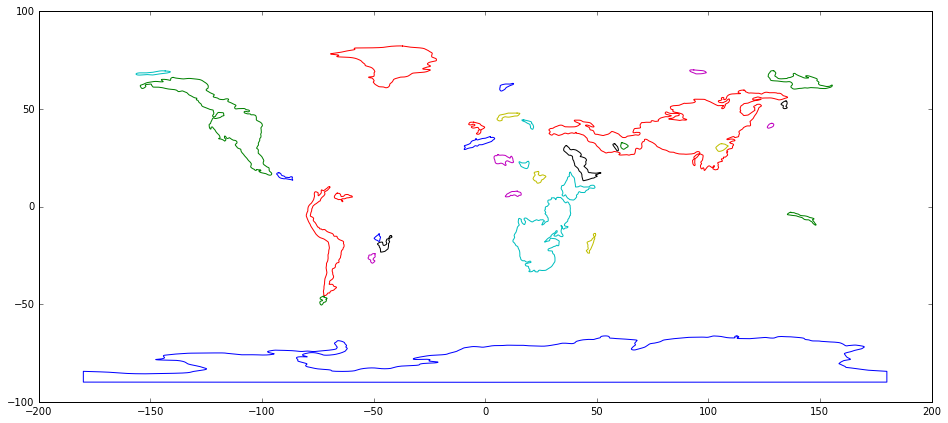

In [13]:
import pygplates
import os
import numpy as np
from skimage import measure
import paleogeography as pg
import polygon_processing as pp
import matplotlib.pyplot as plt

%matplotlib inline


#os.system('gmt grdfilter /Users/Simon/Data/SedThickness/GEBCO1m/GridOne_5m.nc -Gtest.nc -Fg200e -fg -D4 -Vl')

gridX,gridY,gridZ = pg.load_netcdf('/Users/Simon/Data/SedThickness/GEBCO1m/test.nc')

bi = gridZ
sampling = gridX[1]-gridX[0]

pad_hor = np.zeros((1,bi.shape[1]))
pad_ver = np.zeros((bi.shape[0]+2,1))
pad1 = np.vstack((pad_hor,bi,pad_hor))      # add row of zeros to top and bottom
pad2 = np.hstack((pad_ver,pad1,pad_ver))    # add row of zeros to left and right
#pad3 = np.hstack((pad2,pad_ver))
contours = measure.find_contours(pad2, 800, fully_connected='low')
## --- end

contour_polygons = []
contour_features = []

for n,cp in enumerate(contours):

    # To handle edge effects again - strip off parts of polygon
    # due to padding, and adjust from image coordinates to long/lat
    # --- start
    cp[:,1] = (cp[:,1]*sampling)-sampling
    cp[:,0] = (cp[:,0]*sampling)-sampling
    cp[np.where(cp[:,0]<0.),0] = 0
    cp[np.where(cp[:,0]>180.),0] = 180
    cp[np.where(cp[:,1]<0.),1] = 0
    cp[np.where(cp[:,1]>360.),1] = 360
    ## --- end

    cpf = pygplates.PolygonOnSphere(zip(cp[:,0]-90,cp[:,1]-180))
    contour_polygons.append(cpf)

    feature = pygplates.Feature()
    feature.set_geometry(cpf)
    contour_features.append(feature)


area_threshold = 0.001
sieve_polygons_t1 = pp.polygon_area_threshold(contour_features,area_threshold)
    
#plt.imshow(bi)
plt.figure(figsize=(16,7))
for feature in sieve_polygons_t1:
    plt.plot(feature.get_geometry().to_lat_lon_array()[:,1],feature.get_geometry().to_lat_lon_array()[:,0])
